Epoch 1/100


c:\Users\mehja\Desktop\zahra\zehra_thesis\codes\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.3250 - val_loss: 0.1902
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - loss: 0.1484 - val_loss: 0.0543
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.0690 - val_loss: 0.0517
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.0647 - val_loss: 0.0501
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 0.0629 - val_loss: 0.0493
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 0.0621 - val_loss: 0.0480
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.0617 - val_loss: 0.0476
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 246ms/step - loss: 0.0586 - val_loss: 0.0467
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - loss: 0.0572 - val_loss: 0.0494
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - loss: 0.0571 - val_loss: 0.0463
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - loss: 0.0558 - val_loss: 0.0454
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step

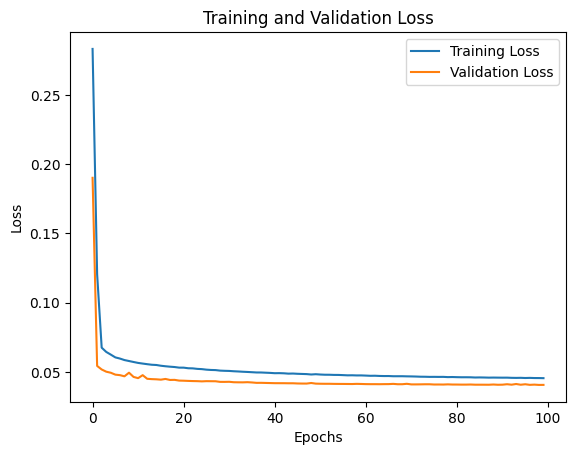

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
df = pd.read_csv('C:/Users/mehja/Desktop/zahra/zehra_thesis/codes/imputed_deu_data1.csv')

# Filter the dataset for Aachen
df_aachen = df[df["City"] == "Aachen"].copy()  # Make a copy to avoid setting on a view

# Clean Latitude and Longitude columns by removing N, S, E, W and converting to float
df_aachen['Latitude'] = df_aachen['Latitude'].replace(r'[^\d.-]', '', regex=True).astype(float)
df_aachen['Longitude'] = df_aachen['Longitude'].replace(r'[^\d.-]', '', regex=True).astype(float)

# Create a new column for 'YearsSince1744' using .loc to avoid the warning
df_aachen.loc[:, "YearsSince1744"] = df_aachen["Year"] - 1744

# Selecting features
features = ['YearsSince1744', 'AverageTemperatureUncertainty','Latitude', 'Longitude', 'TemperatureAnomaly', 'TemperatureChange', 'Yearly_Avg_Temperature']
target = 'AverageTemperature'


# Normalize the feature set
# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(df_aachen[features])
y_scaled = scaler_y.fit_transform(df_aachen[[target]])  # Scale the target separately

# Convert data into sequences (using last 10 years to predict the next year)
def create_sequences(X, y, time_steps=120):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i: i + time_steps])  # Collect past `time_steps` data
        y_seq.append(y[i + time_steps])  # Predict the next value
    return np.array(X_seq), np.array(y_seq)

# Prepare sequences
time_steps = 120
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split into training & validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Build the LSTM model
model = Sequential([
    LSTM(59, activation="relu", input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.4),
   
    Dense(1)
])

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0003), loss="mae")



# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), verbose=1)

# Plot loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# Make predictions
y_pred = model.predict(X_val)

# Inverse transform the predictions and actual values
y_pred_inv = scaler_y.inverse_transform(y_pred)  # Use the correct target scaler
y_val_inv = scaler_y.inverse_transform(y_val)

# Extract corresponding years for validation set
val_start_idx = len(df_aachen) - len(y_val)  # Start index of validation data
years = df_aachen["Year"].iloc[val_start_idx:].values  # Ensure proper alignment

# Plot actual vs. predicted values
plt.figure(figsize=(10, 5))
plt.plot(years, y_val_inv, label="Actual", marker='o', linestyle="-")
plt.plot(years, y_pred_inv, label="Predicted", marker=None, linestyle="--")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.legend()
plt.title("Actual vs. Predicted Temperature (LSTM)")
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


NameError: name 'scaler_y' is not defined

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Predict using the trained model
y_pred = model.predict(X_val)

# Compute MAE, MSE, and R^2
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


ValueError: Found array with dim 3. None expected <= 2.

In [10]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add actual values
fig.add_trace(go.Scatter(
    x=years, 
    y=y_val_inv.flatten(), 
    mode='lines+markers', 
    name='Actual',
    marker=dict(symbol="circle", size=6, color='blue')
))

# Add predicted values
fig.add_trace(go.Scatter(
    x=years, 
    y=y_pred_inv.flatten(), 
    mode='lines+markers', 
    name='Predicted',
    marker=dict(symbol="x", size=8, color='red')
))

# Layout customization
fig.update_layout(
    title="Actual vs. Predicted Temperature (LSTM)",
    xaxis_title="Year",
    yaxis_title="Temperature",
    legend_title="Legend",
    template="plotly_white"
)

# Show figure
fig.show()
